## import library

In [64]:
# Handle table-like data and matrices
import random
import math
import numpy as np
import pandas as pd
from icecream import ic

# Modelling Helpers
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV

# Modelling Algorithms
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
import xgboost

# Configure visualisations
from matplotlib import pyplot as plt 
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as offline
offline.init_notebook_mode(connected = True)

pd.set_option('display.max_columns', 100)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

## import dataset and have an overview of dataset

In [3]:
INPUT_DIR = '/Users/schnappiiii/juypter_notebbok/Lidl case study'
original_dataset = pd.read_csv(f'{INPUT_DIR}/candy-data.csv')
data = original_dataset.copy(deep=True)
data['winpercent'] = data['winpercent'] / 100  # set the format of winpercent the same as other percent
ic(data.shape)
data.head()

ic| data.shape: (85, 13)


,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,0.669717
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,0.676029
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,0.322611
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,0.461165
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,0.523415


This dataset has 85 items and 12 attributes.

In [4]:
data.describe().loc[['mean','std']]

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
mean,0.435294,0.447059,0.164706,0.164706,0.082353,0.082353,0.176471,0.247059,0.517647,0.478647,0.468882,0.503168
std,0.498738,0.500140,0.373116,0.373116,0.276533,0.276533,0.383482,0.433861,0.502654,0.282778,0.285740,0.147144


The number of 1 is more than 0 just in pluribus. It is many candies in a bag or box.

In [5]:
count = []
for i in data.columns[1:-3]:
    c = data[i].value_counts()[1]
    count.append(c)

counts = pd.DataFrame(np.array(count).reshape(1,9), columns=data.columns[1:-3])
counts

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus
0,37,38,14,14,7,7,15,21,44


In [6]:
fig = px.pie(counts, values=counts.loc[0], names=counts.columns,
             title='The number of sugar that contain different characteristic', height=500, width=600)
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()

In the 85 different candies, pluribus accounts for the majority, followed by fruity and chocolate. crispedricewafer and nougat occupy a small percentage.

## data preprocessing

### handle missing values

In [7]:
print('The sorted sum of NaN in each column:')  
null_value = data.isnull().sum()
null_value[null_value>0].sort_values(ascending=False)

The sorted sum of NaN in each column:


Series([], dtype: int64)

### if duplicate rows

In [8]:
print('How many duplicate rows in dataset?:', data.duplicated(keep='last').sum())

How many duplicate rows in dataset?: 0


### count values

In [9]:
# extract useful attributes
df_attribute = data.iloc[:,1:-3]
df_attribute.head()

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus
0,1,0,1,0,0,1,0,1,0
1,1,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0


In [10]:
# attributes and couts in dictionary
dic_attribute = {}
for i in df_attribute:
    dic_attribute[i] = df_attribute.loc[:,i].value_counts()

# dictionary to dataframe
count_attribute = pd.DataFrame.from_dict(dic_attribute)
count_attribute = np.transpose(count_attribute)
count_attribute

,0,1
chocolate,48,37
fruity,47,38
caramel,71,14
peanutyalmondy,71,14
nougat,78,7
crispedricewafer,78,7
hard,70,15
bar,64,21
pluribus,41,44


In [11]:
fig = go.Figure()
fig = px.bar(count_attribute, barmode="group", text_auto=True, opacity=0.8, \
    color_discrete_sequence=['#496595','#c6ccd8'], title="The number of 0&1 in each attribute")
fig.update_layout(xaxis_title="attributes", yaxis_title="counts", bargap=0.2)


From this chart, we can ob see most candies don't contain 'caramel' or 'peanuts, peanut butter, almonds' or 'nougat' or 'crisped rice, wafers, cookie component', are not hard or not candy bar.

### analyze 'pricepercent', 'winpercent'

In [12]:
fig = make_subplots(rows=2, cols=1, subplot_titles=("price percent vs. counts", "win percent vs. counts"))
fig.add_trace(go.Histogram(x=data.pricepercent, opacity=0.8), row=1, col=1)
fig.add_trace(go.Histogram(x=data.winpercent, opacity=0.8), row=2, col=1)

fig.update_xaxes(title_text="price percent", row=1, col=1)
fig.update_yaxes(title_text="counts", row=1, col=1)

fig.update_xaxes(title_text="win percent", row=2, col=1)
fig.update_yaxes(title_text="counts", row=2, col=1)

fig.update_layout(width=1000, height=600, bargap=0.2, margin=dict(b=0,r=20,l=20), showlegend=False)
fig.show()

Text(0.5, 1.0, 'distributions of winpercent')

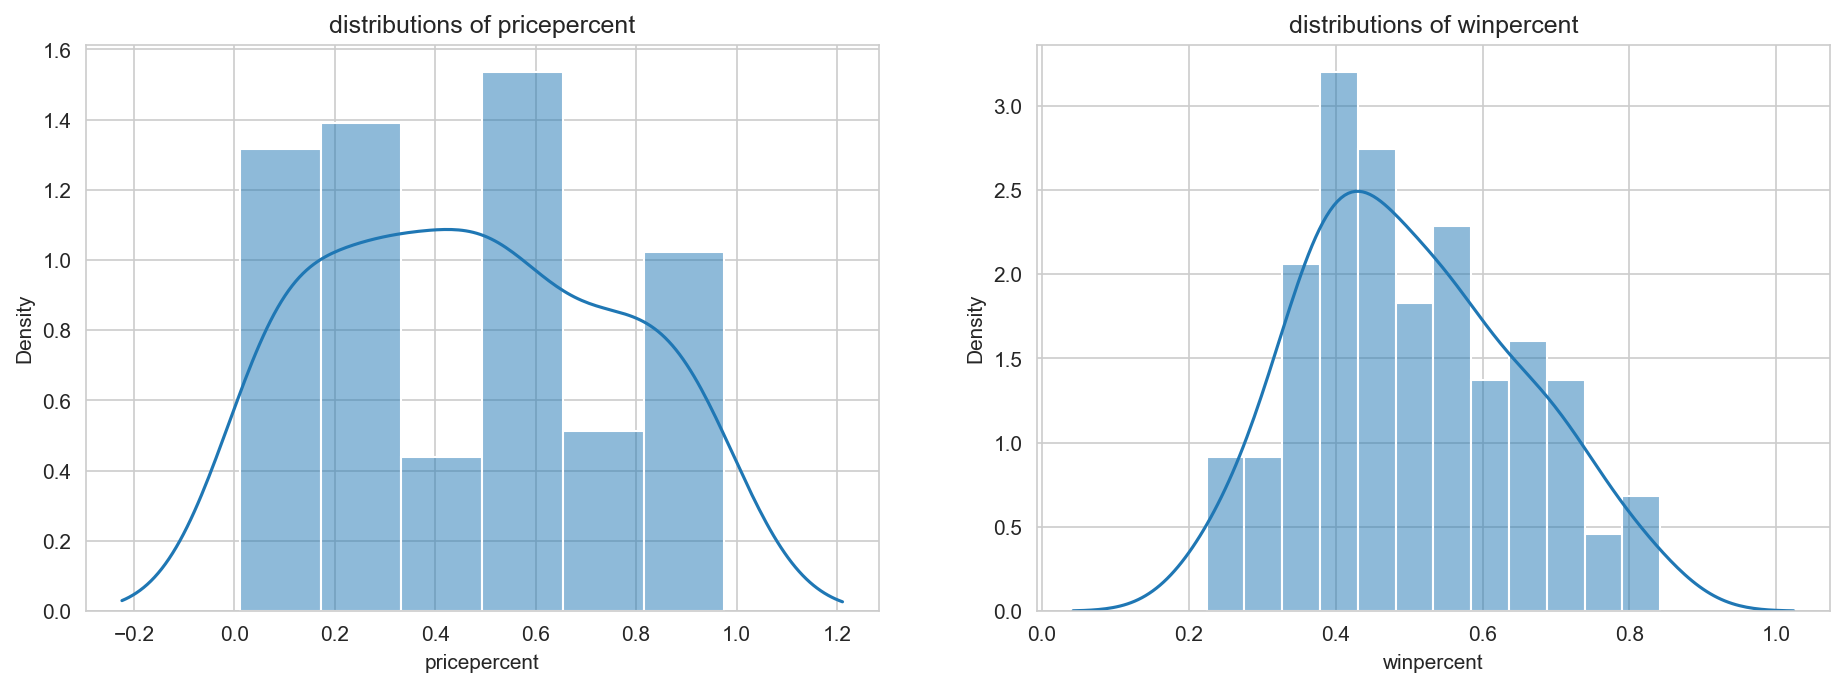

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

sns.histplot(data = data.pricepercent, kde=True, stat="density", bins=6, kde_kws=dict(cut=2), ax=axes[0])
axes[0].set_title('distributions of pricepercent')

sns.histplot(data = data.winpercent, kde=True, stat="density", bins=12, kde_kws=dict(cut=3), ax=axes[1])
axes[1].set_title('distributions of winpercent')

Most price is low and win is concentrated at around 40%.

## relationship and correlation between different features

### heat map

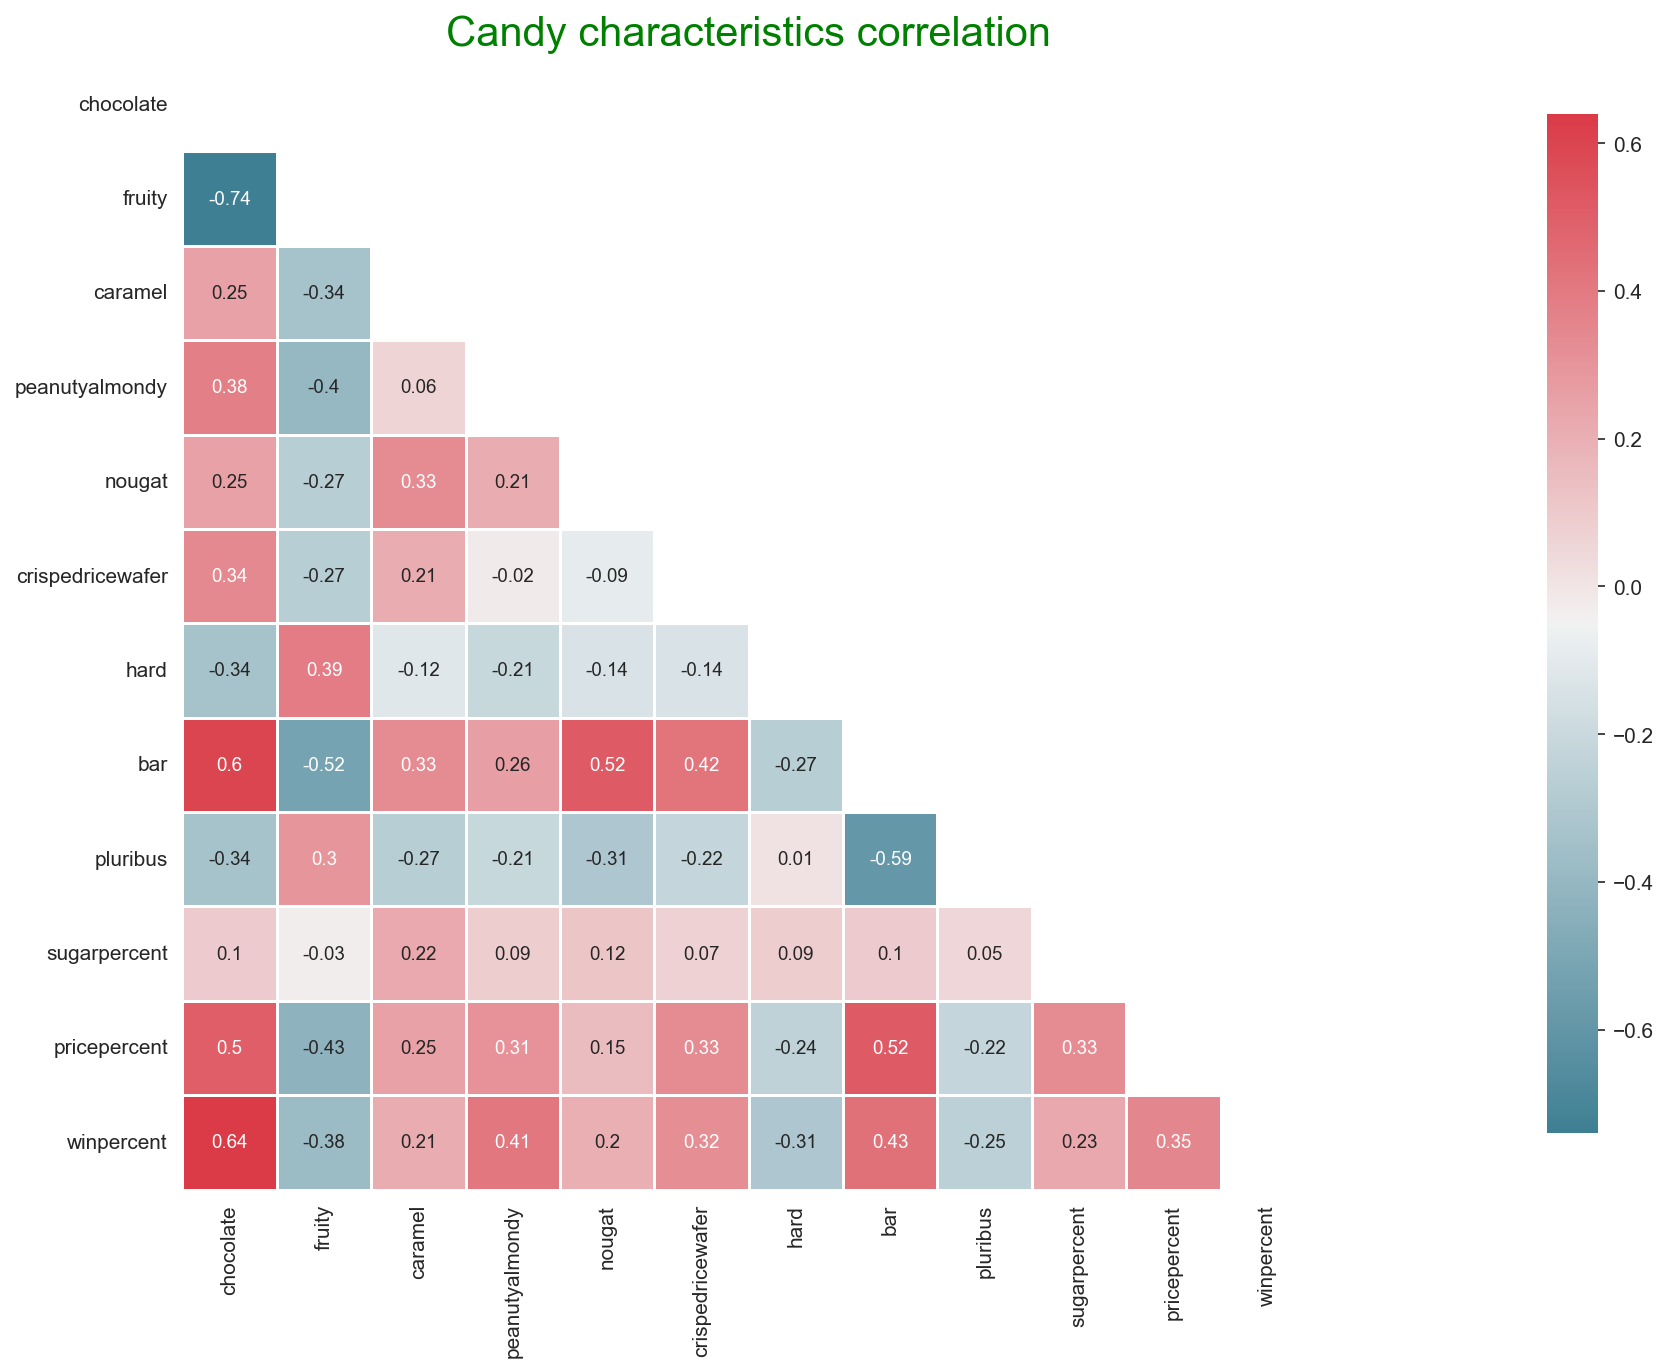

In [14]:
# A heat map of correlation may give us a understanding of which variables are important
def plot_correlation_map(df, title):
    corr = df.corr().round(2)  # correct to two decimal places
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    _ , ax = plt.subplots(figsize =(40, 10), dpi=150)
    cmap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(corr, cmap=cmap, mask = mask, square=True, cbar_kws={'shrink':0.9}, \
        linewidths=0.5, ax=ax, annot=True, annot_kws={'fontsize':9})
    plt.title(title, fontsize=20, color="green")

plot_correlation_map(data, "Candy characteristics correlation") 

In [15]:
# See the correlations in descending order or ascending order
def corr(num):
    corr = data.corr() 
    np.fill_diagonal(corr.values, np.nan)

    corr_unstack = corr.unstack().drop_duplicates()
    corr_des = corr_unstack.sort_values(ascending = False)[:num].reset_index().\
        rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'descending'})
    corr_as= corr_unstack.sort_values(ascending = True)[:num].reset_index().\
        rename(columns={'level_0':'feature_1','level_1':'feature_2',0:'ascending'})
        
    return pd.concat([corr_des,corr_as], axis=1)
corr_sort = corr(num=5)
corr_sort

,feature_1,feature_2,descending,feature_1,feature_2,ascending
0,chocolate,winpercent,0.636517,chocolate,fruity,-0.741721
1,chocolate,bar,0.597421,bar,pluribus,-0.593409
2,nougat,bar,0.522976,fruity,bar,-0.515066
3,bar,pricepercent,0.518407,fruity,pricepercent,-0.430969
4,chocolate,pricepercent,0.504675,fruity,peanutyalmondy,-0.399280


From above, we know that 
- the correlations between chocolate and winpercent are the largest, which means that people like candies with chocolate
- the correlations between chocolate and fruity are the smallest, which means that candies do not mix chocolate and fruits in most cases
- From the row of price percent, chocolate and bar affect price most. Secondly affect sugar and win. Fruity candy has lagest negative correlation with price.
- From the row of win percent, peanutyalmondy, crispedricewafer and bar as well as price have a considerable effect on winning. Fruity candy has lagest negative correlation with win.
- If this candy has chocolate, so it probably is bar and has no fruit, along with peanutyalmondy and crispedricewafer.
- Fruity candy just has positive correlation with hard and pluribus. So, fruity candies often be packed in bags or is hard without other features.
- Caramel almost has nothing to do with peanutyalmondy, with fruity, hard and pluribus into a negative correlation.
- peanutyalmondy nearly has no relation with crispedricewafer and sugar.
- Nougat candy usually accompany caramel and is bar. It has a little correlation with crispedricewafer.
- crispedricewafer can not be hard and no fruit and is a bar.
- Hard candy often fruity and has negative correlation with price and win, this means hard candy is cheap and people don't like hard thing.
- Bar candy is not in bags.
- Fruity candy often in bags and has bags have negative correlation with price and win.
- Sugar has a bit of an effect on prices.

## analyze each type of sugar (distribution and trend, et.)

In [16]:
data['competitorname'] = data['competitorname'].str.replace('Õ',"'")  # deal with special character
sort_data = data.sort_values(by=['winpercent','pricepercent'], ascending=False) # arrange last two columns in descending order
sort_data.head() 

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,Reese's Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,0.841803
51,Reese's Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,0.818663
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,0.816429
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,0.767686
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,0.766738


### chocolate

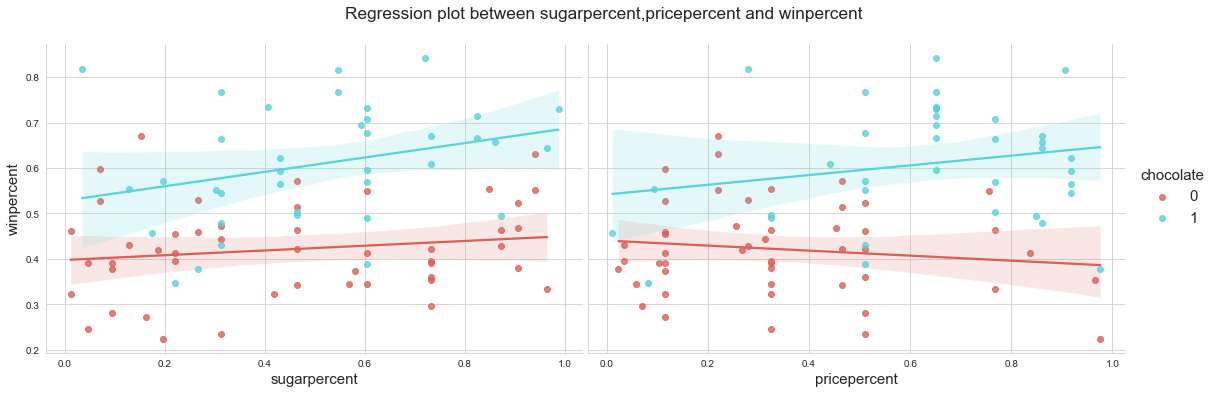

In [17]:
feature = 'chocolate'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()


with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent,pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- From the ranking candies, Reese series seem to be a favourite. 
- Morover, the sugar percent and price of Reese's Miniatures is very low. 

As seen in the distribution chart,
- the top-ranked candies all contain chocolate, verified the conclusions drawn from the heatmap. In contrast, the bottom-ranked candies do not have chocolate, so most people prefer chocolate.
- Candy with chocolate is relatively expensive, but most people like it.

As seen in the regression chart,
- People prefer to eat chocolate candy with high sugar content.
- Expensive chocolate candies are also bought. The more pricey they are, the more likely they sell.

Suggestions:
- Please adding chocolate and increasing sugar content and price.

### fruity

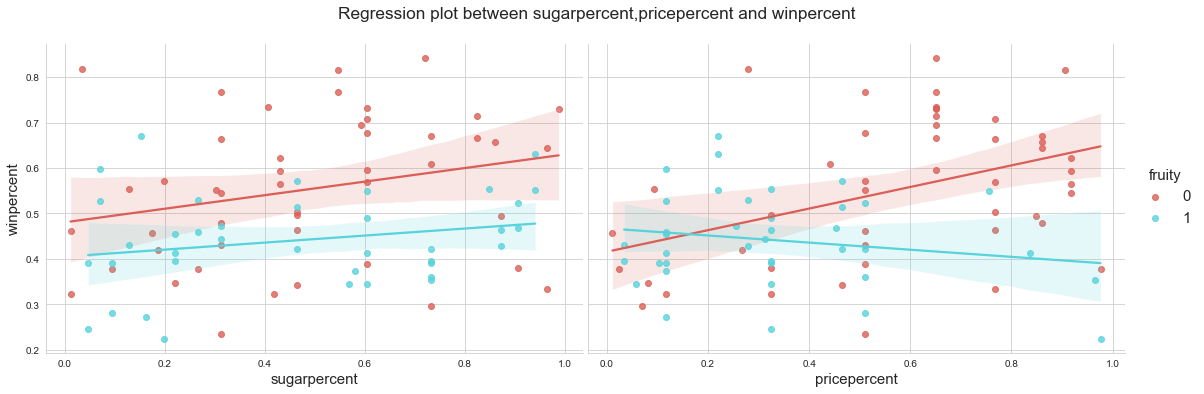

In [18]:
feature = 'fruity'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent,pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- The top sugar has no fruit taste, most people don't like fruity candies.
- Fruity candy is relatively cheaper.
- Whether there is fruit or not in candy, the higher the sugar content, the more people like it.
- The more expensive the fruitless candy the more people like.

Suggestions:
- Please don't yield fruit candies.
- Sweeter and expensive candies without fruit seem to sell better.

### caramel	

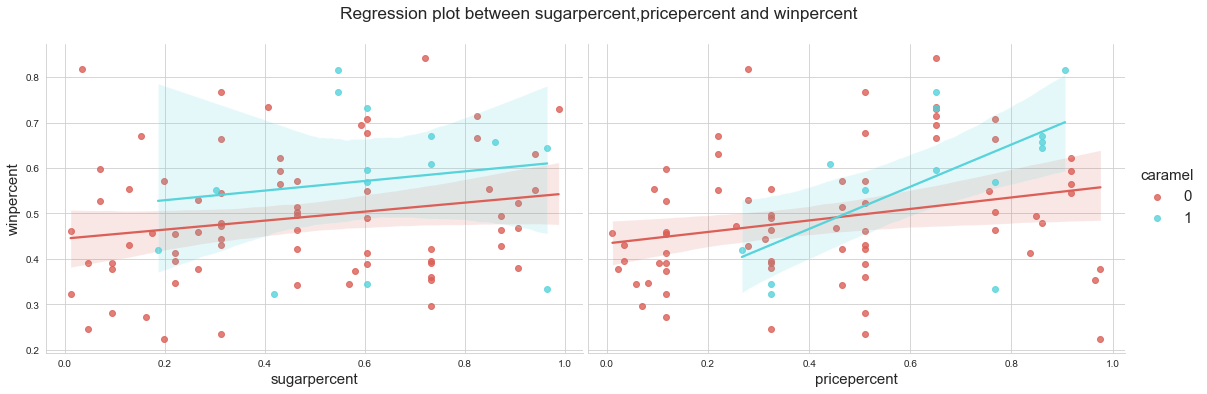

In [19]:
feature = 'caramel'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent,pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- Candies with caramel are a little bit pricey, and most people like them
- The most candies don't have caramel. (imbanlced data)
- People who like caramel are concentrated at both ends.
- Candies with caramel are much sweeter
- People prefer the expensive candy with caramel.

Suggestions:
- It is better to produce the candies with caramel and raise sugar content and preis.

### peanutyalmondy

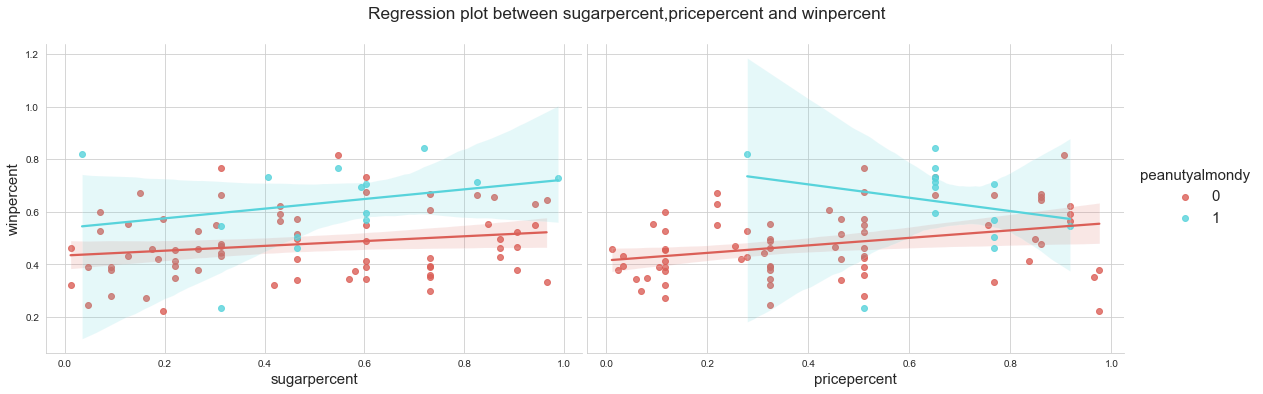

In [20]:
feature = 'peanutyalmondy'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent,pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- Candies with peanutyalmondy is more pricey and more popular.
- Only about 15 percent of the types of sugar containing peanutyalmondy.
- The high preis of candies that contain peanutyalmondy relatively unpopular
- But people are more like candies with peanutyalmondy than without peanutyalmondy, no matter the sugar content or price.
- From bar chart we can also see that sugar containing peanutyalmondy ranked at the top.

Suggestions:
- It is better to produce the candies with peanutyalmondy and raise sugar content but don't increse the preis.

### nougat

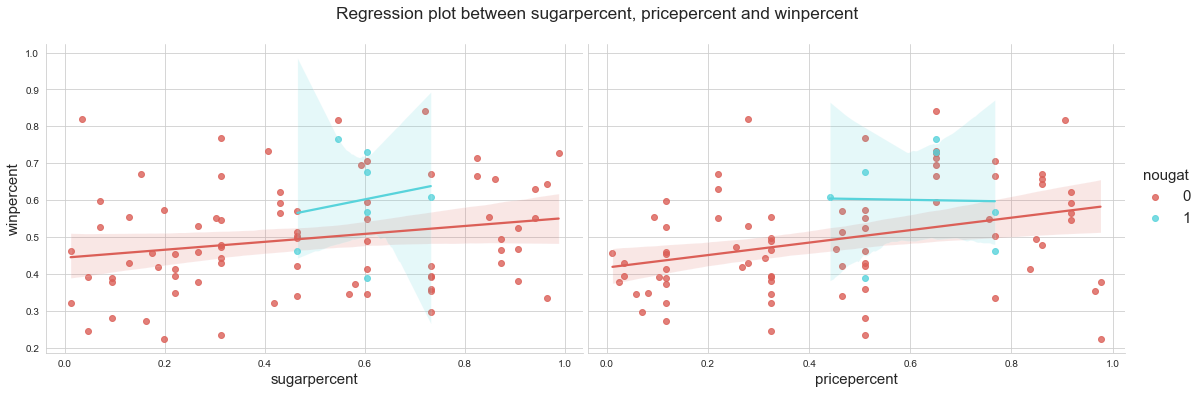

In [21]:
feature = 'nougat'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent, pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- Candies with nougat is more pricey and more popular.
- But only about 8 percent of the types of sugar containing nougat. (Significant data imbalance)
- The higher sugarpercent or pricepercent of candies without nougat, the more popular they are.
- The price seems to have no effect on the candy containing nougat. But the sample are too small.

Suggestions:
- Maybe we can add nougat but the effect is not significantly, so this is not mandatory. 
- Increase the price as much as possible without adding nougat.

### crispedricewafer

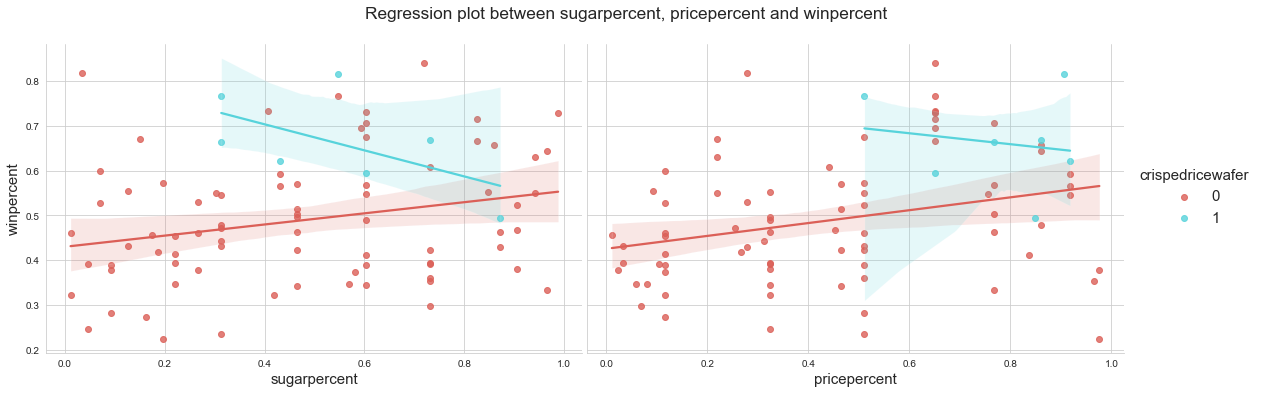

In [22]:
feature = 'crispedricewafer'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent, pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- Candies with crispedricewafer is more pricey and more popular.
- Only about 15 percent of the types of sugar containing crispedricewafer. (Significant data imbalance)
- However, from bar chart candies with crispedricewafer are popular.
- The higher sugarpercent or pricepercent of candies without crispedricewafer, the more popular they are.
- crispedricewafer-containing sugar is the opposite of non-containing. But people always like crispedricewafer.

Suggestion: 
- We can try to add crispedricewafer into candies, but without raising the price and sugar content as much as possible and keep 50% sugar or price percent . 

### hard

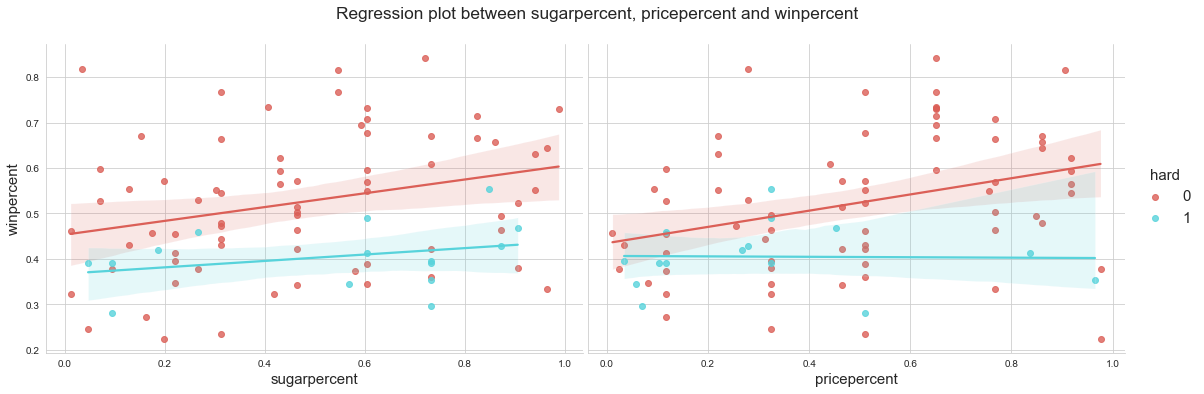

In [23]:
feature = 'hard'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent, pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- It is clear from the chart that hard candies has no advantages popularity.
- Thankfully, most of the sugar is soft.
- The data is very scattered, but overall the higher sugarpercent or pricepercent of soft candies, the more popular they are.

Suggestion: 
- It is better not to produce hard candy.

### bar

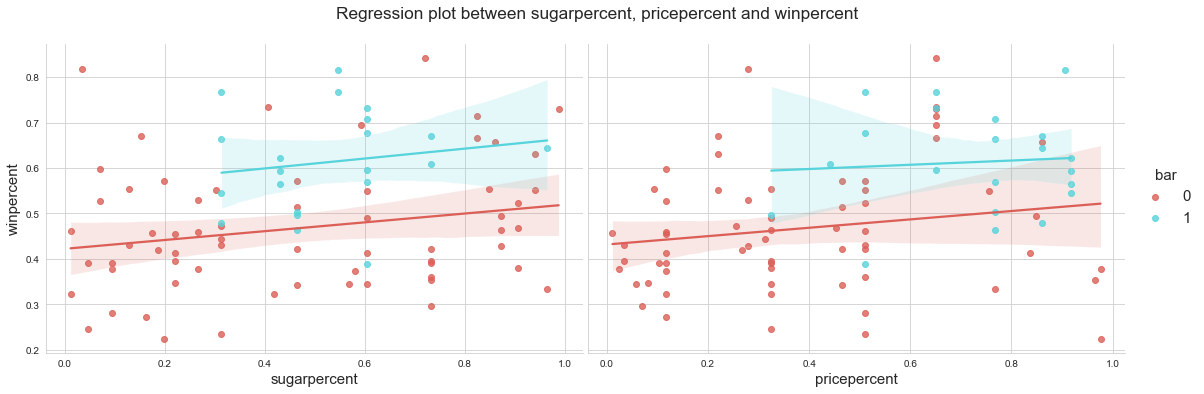

In [24]:
feature = 'bar'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent, pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- Bar sugars have a relative advantage in popularity, but price is also higher.
- About a quarter of the sugar is bar sugar.
- The bars are sweet and expensive, but the price is not a big factor in popularity.

Suggestion: 
- We could make the candy into bars and increase the sugar or price  percent a little bit.

### pluribus

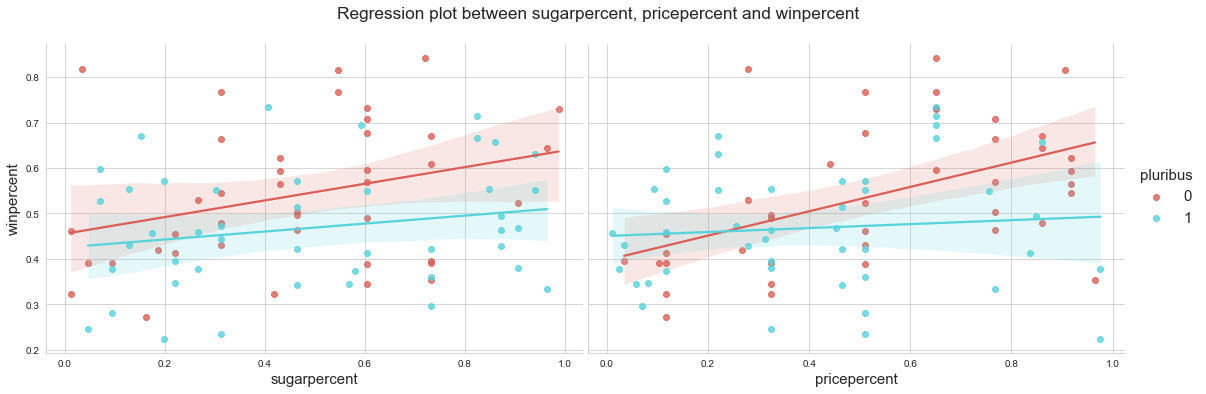

In [25]:
feature = 'pluribus'

fig = make_subplots(rows=2, cols=3, specs=[[{"type": "violin"}, {"type": "violin"}, {"type": "pie"}],[{"colspan": 3},None,None]], \
    column_widths=[0.4,0.4,0.2], row_width=[0.2,0.8], vertical_spacing=0.15, horizontal_spacing=0.02,
    subplot_titles=("Price percentage", "Wining precentage", 
    "Total percentage of Candies", f'According to the ranking, whether the candy contains {feature}'))

fig.add_trace(go.Violin(x=data[feature], y=data['pricepercent'], box_visible=True, \
    meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(x=data[feature], y=data['winpercent'], box_visible=True, \
    meanline_visible=True), row=1, col=2)

fig.add_trace(go.Pie(values=count_attribute.loc[feature].values, \
    marker=dict(colors=['#334668','#C8D0DF']), hole=0.5, 
    hoverinfo='label+percent+value', textinfo='label+percent+value'), row=1, col=3)

fig.add_trace(go.Bar(x=sort_data.competitorname, y=sort_data[feature], width=0.8), row=2, col=1)

fig.update_yaxes(tickvals=[0,1], tick0=0.1, dtick=0.1, showgrid=False, row=2, col=1)

fig.update_layout(width=1300, height=700, bargap=0.2,
                  margin=dict(b=0,r=20,l=20), xaxis=dict(tickmode='linear'),
                  title_text=f'{feature.capitalize()} Analysis (with and without {feature})',
                  template="plotly_white",
                  title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'), showlegend=False)
fig.show()

with sns.plotting_context(rc={'axes.labelsize':15, 'legend.fontsize':15, 'legend.title_fontsize':15}):
    sns.pairplot(data=data, x_vars=['sugarpercent','pricepercent'], y_vars=['winpercent'], \
    palette='hls', kind='reg', hue=feature, height=5, aspect=1.6)
    plt.suptitle('Regression plot between sugarpercent, pricepercent and winpercent', fontsize='xx-large', y=1.08)

Analysis:
- The form of candy is almost no difference.
- Separate candy packaging is relatively slightly good.

Suggestion: 
- Don't pack the candies in a bag.

### simple summary
- We saw that chocolate, caramel, peanutyalmondy, crispedricewafer and bar are the most import features for a candy with high winpercent.
- Most candies are without nougat and there is little difference between whether there is nougat in the candy
- Don't pack the candies in a bag.
- The sweeter the sugar, the more popular it is.

Now, we are looking for the best combination of these features. 

In [26]:
very_important_features = ['chocolate', 'peanutyalmondy', 'caramel']
relation = pd.pivot_table(data, index=very_important_features, values='winpercent', aggfunc=['mean', 'count']).reset_index()
relation.columns = relation.columns.droplevel(level=1)
relation.rename(columns={'mean':'winpercent_mean','count':'winpercent_count'}, inplace=True)
relation.sort_values(by=['winpercent_mean','winpercent_count'], ascending=False, inplace=True)
relation.reset_index(drop=True, inplace=True)
relation

,chocolate,peanutyalmondy,caramel,winpercent_mean,winpercent_count
0,1,1,0,0.698809,9
1,1,0,1,0.668069,7
2,1,1,1,0.643725,3
3,1,0,0,0.535779,18
4,0,0,0,0.431196,42
5,0,0,1,0.355226,4
6,0,1,0,0.348572,2


In [27]:
important_features = ['chocolate', 'peanutyalmondy', 'caramel', 'crispedricewafer', 'bar']
relation = pd.pivot_table(data, index=important_features, values='winpercent', aggfunc=['mean', 'count']).reset_index()
relation.columns = relation.columns.droplevel(level=1)
relation.rename(columns={'mean':'winpercent_mean','count':'winpercent_count'}, inplace=True)
relation.sort_values(by=['winpercent_mean','winpercent_count'], ascending=False, inplace=True)
relation.reset_index(drop=True, inplace=True)
relation

,chocolate,peanutyalmondy,caramel,crispedricewafer,bar,winpercent_mean,winpercent_count
0,1,1,0,0,0,0.755530,6
1,1,0,1,1,1,0.743073,2
2,1,0,0,1,1,0.685079,3
3,1,1,1,0,1,0.667942,2
4,1,0,1,0,1,0.660845,3
5,1,0,1,0,0,0.603902,2
6,1,1,1,1,1,0.595293,1
7,1,1,0,0,1,0.585365,3
8,1,0,0,0,1,0.532980,6
9,1,0,0,1,0,0.495241,1


- It is easy to observe from the two tables above that the winpercent are censentrated between 40% and 55%. These candies contain only chocolate or no these important characteristics.
- If we want the candies that has more over 60% winpercentage, we have to make candies contain chocolate, under this circumstances, select one from peanutyalmondy and caramel or both.

Then, have a look at fruity candies because of its specificity. If this candy don't contain chocolate, so it should have fruity to get more than 60% winpercent.

In [28]:
if np.any(sort_data.query('chocolate==0 & fruity==0 & winpercent>60')) == False:
    print('Candy without chocolate should have fruity to get more than 60% winpercent.')

Candy without chocolate should have fruity to get more than 60% winpercent.


In [29]:
fruity_no_choco = sort_data.query('chocolate==0 & fruity==1 & pluribus==1 & hard==0 & pricepercent<0.3')
print(f'The mean of winpercent: {fruity_no_choco.winpercent.mean().round(2)}')
fruity_no_choco

The mean of winpercent: 0.53


,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
68,Starburst,0,1,0,0,0,0,0,0,1,0.151,0.220,0.670376
60,Skittles original,0,1,0,0,0,0,0,0,1,0.941,0.220,0.630851
66,Sour Patch Kids,0,1,0,0,0,0,0,0,1,0.069,0.116,0.598640
61,Skittles wildberry,0,1,0,0,0,0,0,0,1,0.941,0.220,0.551037
67,Sour Patch Tricksters,0,1,0,0,0,0,0,0,1,0.069,0.116,0.528259
78,Trolli Sour Bites,0,1,0,0,0,0,0,0,1,0.313,0.255,0.471732
15,Fruit Chews,0,1,0,0,0,0,0,0,1,0.127,0.034,0.430889
50,Red vines,0,1,0,0,0,0,0,0,1,0.581,0.116,0.373485


- Candy without chocolate should be fruity, soft, cheap and packed in a bag.

## models

### PCA

In [30]:
pca = PCA(random_state=1)
components = pca.fit_transform(data.iloc[:,1:])

df_pca = pd.DataFrame({'components':range(1,len(data.columns[1:])+1), \
    'explained variance ratio':pca.explained_variance_ratio_, 'cumulative explained variance ratio':np.cumsum(pca.explained_variance_ratio_)})
df_pca

,components,explained variance ratio,cumulative explained variance ratio
0,1,0.428502,0.428502
1,2,0.138658,0.567160
2,3,0.081774,0.648934
3,4,0.071399,0.720333
4,5,0.066571,0.786904
5,6,0.059526,0.846430
6,7,0.044952,0.891382
7,8,0.034410,0.925792
8,9,0.031944,0.957736
9,10,0.023112,0.980848


In [31]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=df_pca.components, y=df_pca['explained variance ratio'], mode='lines+markers'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_pca.components, y=df_pca['cumulative explained variance ratio'], mode='lines+markers', fill='tozeroy'), row=1, col=2)

fig.update_xaxes(title_text="principal components", row=1, col=1)
fig.update_yaxes(title_text="explained variance ratio", row=1, col=1)
fig.update_xaxes(title_text="number of components", row=1, col=2)
fig.update_yaxes(title_text="cumulative explained variance ratio", row=1, col=2)
fig.update_layout(title_text='PCA', title_font=dict(size=29, color='#8a8d93', family="Lato, sans-serif"), showlegend=False)
fig.show()

The sum of first 3 explained variances is just about 0.65, not so good.

In [32]:
comp2 = pd.DataFrame({'features':data.iloc[:,1:].columns, 'PC1':pca.components_[0],'PC2':pca.components_[1]})
px.scatter(comp2, x='PC1', y='PC2', color='features', text="features")

In [33]:
comp3 = pd.DataFrame({'features':data.iloc[:,1:].columns, 'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2]})
px.scatter_3d(comp3, x='PC1', y='PC2', z='PC3', color='features', labels={'0':'PC 1', '1':'PC 2', '2':'PC 3'})

Chocolate and bar are the most important. Hard, fruity and pluribus has the opposite direction for winpercent, therefore, try not to include these several features in the candy.

### Random forest regressor

In [44]:
features = data.columns[1:-1]
X_train = data.iloc[:,1:-1]
y_train = data.winpercent.ravel()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, \
    'max_depth': max_depth, 'min_samples_split': min_samples_split, 
    'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
rfg = RandomForestRegressor()
model_rfg = RandomizedSearchCV(estimator = rfg, param_distributions=random_grid, \
    n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_rfg.fit(X_train, y_train)

pred_rfg = cross_val_predict(model_rfg.best_estimator_, X_train, y_train, cv=4, n_jobs=2)

print(f'model_rfg best parameters: {model_rfg.best_params_}, \nR2 score: {metrics.r2_score(y_train, pred_rfg)}, \
    \nRoot Mean Square Error: {math.sqrt(metrics.mean_squared_error(y_train, pred_rfg))}')

model_rfg best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}, 
R2 score: 0.3059179233325495,     
Root Mean Square Error: 0.12186441160440716


In [45]:
df_rfg = pd.DataFrame({'feature': features, 'importance': model_rfg.best_estimator_.feature_importances_})
px.bar(df_rfg, x='feature', y='importance').update_xaxes(categoryorder="total descending")

We see that chocolate is the most important feature, then pricepercent, bar and peanutalmondy.

In [46]:
X_train = data.iloc[:,1:-1]
y_train = data.winpercent.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
rfg = RandomForestRegressor()
model_rfg = RandomizedSearchCV(estimator = rfg, param_distributions=random_grid, \
    n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_rfg.fit(X_train, y_train)
y_train_pred = model_rfg.predict(X_train)
y_test_pred = model_rfg.predict(X_test)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test =metrics.r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
df_rfg = pd.DataFrame({'feature': features, 'importance': model_rfg.best_estimator_.feature_importances_})
px.bar(df_rfg, x='feature', y='importance').update_xaxes(categoryorder="total descending")

R^2 train: 0.79
R^2 test: 0.40


In [63]:
X_train = data.iloc[:,1:-1]
y_train = data.winpercent.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
model_rfg = RandomForestRegressor()
# model_rfg = RandomizedSearchCV(estimator = rfg, param_distributions=random_grid, \
#     n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_rfg.fit(X_train, y_train)
y_train_pred = model_rfg.predict(X_train)
y_test_pred = model_rfg.predict(X_test)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test =metrics.r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
df_rfg = pd.DataFrame({'feature': X_train.columns, 'importance': model_rfg.feature_importances_})
px.bar(df_rfg, x='feature', y='importance').update_xaxes(categoryorder="total descending")


R^2 train: 0.90
R^2 test: 0.35


### XGB regressor

In [266]:
features = data.columns[1:-1]
target = 'winpercent'

hyperparameter_grid = {'n_estimators': [100, 500, 900, 1100, 1500], \
    'max_depth': [2, 3, 5, 10, 15], 'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4], 'eval_metric':['logloss','auc','error']}
    
xgb = xgboost.XGBRegressor(objective = 'binary:logistic')
model_xgb = RandomizedSearchCV(estimator = xgb, param_distributions=hyperparameter_grid, \
    n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_xgb.fit(X_train, y_train)

pred_xgb = cross_val_predict(model_xgb.best_estimator_, X_train, y_train, cv=4, n_jobs=2)

# R2_score=1, the predicted and true values are exactly equal without any error, indicating that the better the independent variable explains the dependent variable in the regression analysis.
# R2_score=0, the numerator equals the denominator and each predicted value is equal to the mean value.
print(f'model_xgb best parameters: {model_xgb.best_params_}, \nR2 score: {metrics.r2_score(y_train, pred_xgb)}, \
    \nRoot Mean Square Error: {math.sqrt(metrics.mean_squared_error(y_train, pred_xgb))}')

model_xgb best parameters: {'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.05, 'eval_metric': 'auc'}, 
R2 score: 0.3597119629526271,     
Root Mean Square Error: 0.11704670030847357


In [267]:
df_xgb = pd.DataFrame({'feature': features, 'importance': model_xgb.best_estimator_.feature_importances_})
px.bar(df_xgb, x='feature', y='importance').update_xaxes(categoryorder="total descending")

We see that chocolate is the most important feature.

In [49]:
features = data.columns[1:-1]
target = 'winpercent'
X_train = data.iloc[:,1:-1]
y_train = data.winpercent
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

hyperparameter_grid = {'n_estimators': [100, 500, 900, 1100, 1500], \
    'max_depth': [2, 3, 5, 10, 15], 'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4], 'eval_metric':['logloss','auc','error']}
    
xgb = xgboost.XGBRegressor(objective = 'binary:logistic')
model_xgb = RandomizedSearchCV(estimator = xgb, param_distributions=hyperparameter_grid, \
    n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_xgb.fit(X_train, y_train)
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test =metrics.r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
df_xgb = pd.DataFrame({'feature': features, 'importance': model_xgb.best_estimator_.feature_importances_})
px.bar(df_xgb, x='feature', y='importance').update_xaxes(categoryorder="total descending")

R^2 train: 0.70
R^2 test: 0.38


In [68]:
features = data.columns[1:-1]
target = 'winpercent'
X_train = data.iloc[:,1:-1]
y_train = data.winpercent
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

hyperparameter_grid = {'n_estimators': [100, 500, 900, 1100, 1500], \
    'max_depth': [2, 3, 5, 10, 15], 'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4], 'eval_metric':['logloss','auc','error']}
    
model_xgb = xgboost.XGBRegressor(objective='binary:logistic', eval_metric='logloss')
# model_xgb = RandomizedSearchCV(estimator = xgb, param_distributions=hyperparameter_grid, \
#     n_iter=20, cv=4, refit=True, random_state=42, n_jobs=2)

model_xgb.fit(X_train, y_train)
y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test =metrics.r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
df_xgb = pd.DataFrame({'feature': features, 'importance': model_xgb.feature_importances_})
px.bar(df_xgb, x='feature', y='importance').update_xaxes(categoryorder="total descending")

R^2 train: 0.98
R^2 test: 0.30


## Ridge regression

In [73]:
features = data.columns[1:-1]
target = 'winpercent'
X_train = data.iloc[:,1:-1]
y_train = data.winpercent
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

ridge_ = Ridge(alpha=1.0)
ridge_.fit(X_train, y_train)

y_train_pred = ridge_.predict(X_train)
y_test_pred = ridge_.predict(X_test)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test =metrics.r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')
df_xgb = pd.DataFrame({'feature': features, 'importance': ridge_.coef_})
px.bar(df_xgb, x='feature', y='importance').update_xaxes(categoryorder="total descending")

R^2 train: 0.59
R^2 test: 0.33


## summary

Some of the interesting conclusions about this analysis:

1) __Chocolate__ is the most effective component which affects the popularity. In caontrary, __Fruity__ goes in a completly different direction as others.

2) __Do not make fruit candies or hard candies packt in a bag__ as much as possible.

3) Candies containing __chocolate and caramel or peanutyalmondy__ in the forms __bar or crispedricewafer__ are more probable to sell.

4) __Candy without chocolate__ should be fruity, soft, cheap and packed in a bag.

5) If we want the candies that has more over 60% winpercentage, we have to make candies contain chocolate, under this circumstances, select one from peanutyalmondy and caramel or both.

7) __Recommendotion__: Soft bar candy with chocolate and without fruit, separate packing, select peanutyalmondy or crispedricewafer or caramel one or more. The price can be increased to more than 60 percent.

